In [1]:
# Food Delivery Time Prediction
# Exploratory Data Analysis (EDA) Notebook

# Goal:
# Predict delivery time (Delivery_Time_min) based on features such as
# distance, weather, traffic, courier experience, etc.


In [ ]:
# Core libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import geopy.distance
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# Global constants
TIME_FMT = '%H:%M'
DATE_FMT = '%d-%m-%Y'
SEED = 359

In [4]:
PATH = "../data/Zomato Dataset.csv"


In [5]:
df = pd.read_csv(PATH,parse_dates=['Order_Date'],infer_datetime_format=True,date_format=DATE_FMT,dayfirst=True)

# drop NULLs 
df.dropna(inplace=True)

# drop unwanted column/s 
unwanted_cols = ['ID']
df.drop(unwanted_cols, inplace=True, axis=1)

# renaming column = time_taken(min)
df.rename(columns={'Time_taken (min)':'Time_taken_min'}, inplace=True)

# formatting column names -- optional
df.columns = [c.lower() for c in df.columns]

# sort by order_date (old to new)
df.sort_values(by=['order_date'],inplace=True)
df.reset_index(drop=True, inplace=True)


# view
print(f"Data Shape: {df.shape}\n\n")
df.head()

/tmp/ipykernel_34640/4271769451.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(PATH,parse_dates=['Order_Date'],infer_datetime_format=True,date_format=DATE_FMT,dayfirst=True)


Data Shape: (41359, 19)




,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min
0,KOLRES19DEL02,27.0,4.4,-22.549100,88.400467,22.569100,88.420467,2022-02-11,11:55,12:10,Sunny,High,0,Snack,motorcycle,2.0,No,Metropolitian,49
1,ALHRES07DEL01,22.0,4.1,25.449659,81.839744,25.459659,81.849744,2022-02-11,09:45,09:50,Windy,Low,0,Meal,motorcycle,0.0,No,Metropolitian,16
2,AURGRES13DEL02,24.0,5.0,19.880256,75.323503,19.930256,75.373503,2022-02-11,17:45,17:50,Cloudy,Medium,1,Buffet,motorcycle,1.0,No,Metropolitian,15
3,AURGRES12DEL01,34.0,4.8,19.879631,75.323403,19.919631,75.363403,2022-02-11,16:15,16:20,Windy,Medium,1,Snack,motorcycle,1.0,No,Metropolitian,34
4,LUDHRES010DEL01,29.0,4.7,30.892860,75.822199,30.932860,75.862199,2022-02-11,15:40,15:50,Fog,Medium,2,Drinks,electric_scooter,0.0,No,Metropolitian,17


In [ ]:
# -------------------------------
# De-duplication criteria #1
# -------------------------------
dup_c1 = [
    'delivery_person_id',
    'delivery_person_age',
    'order_date',
    'time_orderd'
]

# Drop duplicates (keep=None → remove all duplicates)
df = df[~df.duplicated(subset=dup_c1, keep=False)]

# -------------------------------
# De-duplication criteria #2
# -------------------------------
dup_c2 = [
    'delivery_person_id',
    'delivery_person_age',
    'delivery_person_ratings'
]

# Drop duplicates (keep='first' → keep first occurrence)
df = df[~df.duplicated(subset=dup_c2, keep='first')]

# -------------------------------
# Quick check
# -------------------------------
print(f"Data Shape after de-duplication: {df.shape}\n\n")
df.head()


Data Shape after de-duplication: (36517, 19)




,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min
0,KOLRES19DEL02,27.0,4.4,-22.549100,88.400467,22.569100,88.420467,2022-02-11,11:55,12:10,Sunny,High,0,Snack,motorcycle,2.0,No,Metropolitian,49
1,ALHRES07DEL01,22.0,4.1,25.449659,81.839744,25.459659,81.849744,2022-02-11,09:45,09:50,Windy,Low,0,Meal,motorcycle,0.0,No,Metropolitian,16
2,AURGRES13DEL02,24.0,5.0,19.880256,75.323503,19.930256,75.373503,2022-02-11,17:45,17:50,Cloudy,Medium,1,Buffet,motorcycle,1.0,No,Metropolitian,15
3,AURGRES12DEL01,34.0,4.8,19.879631,75.323403,19.919631,75.363403,2022-02-11,16:15,16:20,Windy,Medium,1,Snack,motorcycle,1.0,No,Metropolitian,34
4,LUDHRES010DEL01,29.0,4.7,30.892860,75.822199,30.932860,75.862199,2022-02-11,15:40,15:50,Fog,Medium,2,Drinks,electric_scooter,0.0,No,Metropolitian,17


In [7]:
#Convert age to int
df['delivery_person_age'] = df['delivery_person_age'].astype(int)
   

In [8]:
# Convert time columns to datetime, invalid entries become NaT
df['time_orderd'] = pd.to_datetime(df['time_orderd'], format='%H:%M', errors='coerce')
df['time_order_picked'] = pd.to_datetime(df['time_order_picked'], format='%H:%M', errors='coerce')

# Compute pickup time in minutes
df['pickup_time_min'] = (df['time_order_picked'] - df['time_orderd']).dt.total_seconds() / 60

# Remove rows with null pickup time
df = df.dropna(subset=['pickup_time_min'])

# Convert to integer
df['pickup_time_min'] = df['pickup_time_min'].astype(np.int64)

# Drop original time columns
df.drop(['time_orderd', 'time_order_picked'], axis=1, inplace=True)

# Preview result
df[['pickup_time_min']].head()

,pickup_time_min
0,15
1,5
2,5
3,5
4,10


In [9]:
# Define the distance function
def get_distance(rlat: float, rlon: float, dlat: float, dlon: float):
    """
    Compute the distance (km) between two geo-coordinates.
    The order of arguments is restaurant > delivery location.
    """
    res_coords = (abs(rlat), abs(rlon))
    dl_coords = (abs(dlat), abs(dlon))
    try:
        dist = geopy.distance.geodesic(res_coords, dl_coords).km
        return round(dist, 2)
    except:
        return None

# Calculate distance for each row
df['delivery_dist_km'] = df.apply(lambda row: get_distance(
    row['restaurant_latitude'],
    row['restaurant_longitude'],
    row['delivery_location_latitude'],
    row['delivery_location_longitude']
), axis=1)

# Drop original latitude and longitude columns
unwanted_cols = ['restaurant_latitude','restaurant_longitude',
                 'delivery_location_latitude','delivery_location_longitude']
df.drop(unwanted_cols, axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

# Preview result
df[['delivery_dist_km']].head()


,delivery_dist_km
0,3.02
1,1.50
2,7.62
3,6.10
4,5.86


In [10]:
# Extract month from order_date
df['month'] = df['order_date'].dt.month

# Mark weekends: yes if Saturday or Sunday, no otherwise
df['weekend'] = df['order_date'].dt.weekday.apply(lambda x: 'yes' if x >= 5 else 'no')

# Drop original order_date column
df.drop('order_date', axis=1, inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# Preview result
df[['month', 'weekend']].head()


,month,weekend
0,2,no
1,2,no
2,2,no
3,2,no
4,2,no


In [ ]:
# Convert 'multiple_deliveries' to categorical
df['multiple_deliveries'] = df['multiple_deliveries'].apply(lambda x: 'no' if x == 0.0 else 'yes')

# Drop person-specific columns
df.drop(['delivery_person_id', 'delivery_person_age', 'delivery_person_ratings'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

# Label encode categorical columns
cat_cols = ['weather_conditions','road_traffic_density','type_of_order','type_of_vehicle',
            'multiple_deliveries','festival','city','weekend','vehicle_condition']
df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)

# Re-arrange columns
new_col_order = ['weather_conditions', 'road_traffic_density', 'vehicle_condition',
                 'type_of_order','type_of_vehicle','multiple_deliveries','festival','city',
                 'pickup_time_min','delivery_dist_km','month','weekend','time_taken_min']
df = df[new_col_order]

# Scale numerical columns using Min-Max
scaler = MinMaxScaler()
num_cols = ['pickup_time_min','delivery_dist_km']
df[num_cols] = scaler.fit_transform(df[num_cols])

# Preview cleaned & pre-processed dataframe
print(f"Data Shape: {df.shape}\n")
df.head()


Data Shape: (29486, 13)



,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,pickup_time_min,delivery_dist_km,month,weekend,time_taken_min
0,4,0,0,3,1,1,0,0,1.0,0.080082,2,0,49
1,5,2,0,2,1,0,0,0,0.0,0.002053,2,0,16
2,0,3,1,0,1,1,0,0,0.0,0.316222,2,0,15
3,5,3,1,3,1,1,0,0,0.0,0.238193,2,0,34
4,1,3,2,1,0,0,0,0,0.5,0.225873,2,0,17


In [ ]:
# Categorical and numerical columns
categorical_cols = ['weather_conditions','road_traffic_density','vehicle_condition',
                    'type_of_order','type_of_vehicle','multiple_deliveries','festival','city','month','weekend']
num_cols = ['pickup_time_min','delivery_dist_km']

# Split features and target
X = df[categorical_cols + num_cols]
y = df['time_taken_min'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate categorical and numerical
X_train_cat = X_train[categorical_cols].values
X_train_num = X_train[num_cols].values
X_test_cat = X_test[categorical_cols].values
X_test_num = X_test[num_cols].values

# Scale numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

# Categorical input
cat_input = Input(shape=(X_train_cat.shape[1],), name='cat_input')
cat_dense = Dense(32, activation='relu')(cat_input)

# Numerical input
num_input = Input(shape=(X_train_num.shape[1],), name='num_input')
num_dense = Dense(16, activation='relu')(num_input)

# Concatenate
concat = Concatenate()([cat_dense, num_dense])
x = Dense(64, activation='relu')(concat)
x = Dense(32, activation='relu')(x)
output = Dense(1)(x)

# Build model
model = Model(inputs=[cat_input, num_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Save the best model during training
checkpoint = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_mae', 
    mode='min', 
    save_best_only=True, 
    verbose=1
)

# Train model
history = model.fit(
    [X_train_cat, X_train_num], y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint],
    verbose=1
)

# Load the best weights
model.load_weights('best_model.h5')

# Evaluate on test set
test_loss, test_mae = model.evaluate([X_test_cat, X_test_num], y_test)
print(f"Best Test MAE: {test_mae:.2f}")


I0000 00:00:1758818564.839085   34640 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1758818566.919338   34640 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1758818566.921626   34640 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1758818567.161671   34640 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:2b:00.0, compute capability: 12.0a


Epoch 1/50


I0000 00:00:1758818569.584226   34728 service.cc:158] XLA service 0x711ba8003770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758818569.584264   34728 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0a
I0000 00:00:1758818569.622533   34728 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758818569.844232   34728 cuda_dnn.cc:463] Loaded cuDNN version 91300
I0000 00:00:1758818570.414945   34800 subprocess_compilation.cc:347] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_MatMul_26', 12 bytes spill stores, 12 bytes spill loads



 56/590 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 620.5626 - mae: 22.6204

I0000 00:00:1758818572.186941   34728 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


589/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 215.8732 - mae: 11.2313

I0000 00:00:1758818574.434119   34884 subprocess_compilation.cc:347] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_MatMul_26', 12 bytes spill stores, 12 bytes spill loads



590/590 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 215.6920 - mae: 11.2258
Epoch 1: val_mae improved from None to 6.39588, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 108.9314 - mae: 7.9550 - val_loss: 62.5210 - val_mae: 6.3959
Epoch 2/50
577/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56.2429 - mae: 6.0328
Epoch 2: val_mae improved from 6.39588 to 5.89095, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 55.1091 - mae: 5.9715 - val_loss: 53.2876 - val_mae: 5.8909
Epoch 3/50
576/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.4154 - mae: 5.7206
Epoch 3: val_mae improved from 5.89095 to 5.72758, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 49.7410 - mae: 5.6657 - val_loss: 50.4030 - val_mae: 5.7276
Epoch 4/50
579/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48.5706 - mae: 5.5984
Epoch 4: val_mae improved from 5.72758 to 5.56329, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 47.0621 - mae: 5.5040 - val_loss: 48.2031 - val_mae: 5.5633
Epoch 5/50
580/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.0819 - mae: 5.3653
Epoch 5: val_mae improved from 5.56329 to 5.52156, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 45.3236 - mae: 5.3918 - val_loss: 47.1651 - val_mae: 5.5216
Epoch 6/50
585/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.5962 - mae: 5.2823
Epoch 6: val_mae improved from 5.52156 to 5.33459, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 44.0593 - mae: 5.3159 - val_loss: 45.2211 - val_mae: 5.3346
Epoch 7/50
574/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.5372 - mae: 5.2268
Epoch 7: val_mae did not improve from 5.33459
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 42.8535 - mae: 5.2475 - val_loss: 44.3590 - val_mae: 5.3397
Epoch 8/50
585/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.8218 - mae: 5.1535
Epoch 8: val_mae did not improve from 5.33459
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 41.8790 - mae: 5.1719 - val_loss: 44.7809 - val_mae: 5.3548
Epoch 9/50
580/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.7984 - mae: 5.1126
Epoch 9: val_mae improved from 5.33459 to 5.18165, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 41.0762 - mae: 5.1212 - val_loss: 42.0813 - val_mae: 5.1816
Epoch 10/50
585/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.4297 - mae: 5.0611
Epoch 10: val_mae improved from 5.18165 to 5.08021, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 40.1102 - mae: 5.0449 - val_loss: 41.0537 - val_mae: 5.0802
Epoch 11/50
585/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39.8023 - mae: 5.0207
Epoch 11: val_mae did not improve from 5.08021
590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 39.6557 - mae: 5.0173 - val_loss: 41.1489 - val_mae: 5.1175
Epoch 12/50
578/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39.1331 - mae: 4.9739
Epoch 12: val_mae improved from 5.08021 to 4.98387, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 39.0263 - mae: 4.9799 - val_loss: 39.9484 - val_mae: 4.9839
Epoch 13/50
581/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.8131 - mae: 4.9089
Epoch 13: val_mae improved from 4.98387 to 4.96264, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 38.5263 - mae: 4.9395 - val_loss: 39.8885 - val_mae: 4.9626
Epoch 14/50
583/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39.3665 - mae: 4.9958
Epoch 14: val_mae improved from 4.96264 to 4.93128, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 38.2548 - mae: 4.9172 - val_loss: 39.2671 - val_mae: 4.9313
Epoch 15/50
587/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.8862 - mae: 4.9013
Epoch 15: val_mae did not improve from 4.93128
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 37.9846 - mae: 4.8925 - val_loss: 41.8797 - val_mae: 5.1001
Epoch 16/50
588/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.1995 - mae: 4.9048
Epoch 16: val_mae did not improve from 4.93128
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 37.6499 - mae: 4.8758 - val_loss: 39.2297 - val_mae: 4.9410
Epoch 17/50
155/590 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 35.2175 - mae: 4.6944
Epoch 17: val_mae improved from 4.93128 to 4.92353, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 37.4802 - mae: 4.8593 - val_loss: 39.0514 - val_mae: 4.9235
Epoch 18/50
586/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.6441 - mae: 4.8732
Epoch 18: val_mae improved from 4.92353 to 4.89556, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 37.1876 - mae: 4.8444 - val_loss: 38.8837 - val_mae: 4.8956
Epoch 19/50
587/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.9196 - mae: 4.8868
Epoch 19: val_mae did not improve from 4.89556
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 37.1398 - mae: 4.8368 - val_loss: 39.0468 - val_mae: 4.9036
Epoch 20/50
579/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.3672 - mae: 4.7936
Epoch 20: val_mae improved from 4.89556 to 4.86211, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 36.9239 - mae: 4.8242 - val_loss: 38.3125 - val_mae: 4.8621
Epoch 21/50
575/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.1751 - mae: 4.8387
Epoch 21: val_mae did not improve from 4.86211
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 36.8343 - mae: 4.8173 - val_loss: 38.1423 - val_mae: 4.8751
Epoch 22/50
582/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.0924 - mae: 4.7564
Epoch 22: val_mae did not improve from 4.86211
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 36.4850 - mae: 4.7860 - val_loss: 38.5387 - val_mae: 4.8643
Epoch 23/50
571/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.1654 - mae: 4.7778
Epoch 23: val_mae improved from 4.86211 to 4.82199, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 36.3082 - mae: 4.7775 - val_loss: 37.5927 - val_mae: 4.8220
Epoch 24/50
588/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.2491 - mae: 4.7747
Epoch 24: val_mae did not improve from 4.82199
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 36.2591 - mae: 4.7802 - val_loss: 37.8120 - val_mae: 4.8338
Epoch 25/50
582/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.0295 - mae: 4.7711
Epoch 25: val_mae did not improve from 4.82199
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 36.1898 - mae: 4.7761 - val_loss: 38.4697 - val_mae: 4.9106
Epoch 26/50
576/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.6098 - mae: 4.7337
Epoch 26: val_mae improved from 4.82199 to 4.81569, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 36.0080 - mae: 4.7589 - val_loss: 37.3416 - val_mae: 4.8157
Epoch 27/50
587/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.5604 - mae: 4.7273
Epoch 27: val_mae did not improve from 4.81569
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 35.6545 - mae: 4.7317 - val_loss: 41.5215 - val_mae: 5.0317
Epoch 28/50
575/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.6536 - mae: 4.7248
Epoch 28: val_mae did not improve from 4.81569
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 35.5268 - mae: 4.7241 - val_loss: 37.6679 - val_mae: 4.8224
Epoch 29/50
578/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.2200 - mae: 4.7133
Epoch 29: val_mae did not improve from 4.81569
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 35.4559 - mae: 4.7206 - val_loss: 37.6506 - val_mae: 4.8234
Epoch 30/50
579/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.5683 - mae: 4.6741
Epoch 30: val_mae did not improve from 4.81569
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - l

590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 34.9628 - mae: 4.6905 - val_loss: 36.9904 - val_mae: 4.7722
Epoch 33/50
588/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.4966 - mae: 4.6452
Epoch 33: val_mae did not improve from 4.77218
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 34.7778 - mae: 4.6699 - val_loss: 37.2538 - val_mae: 4.8053
Epoch 34/50
577/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.0066 - mae: 4.6351
Epoch 34: val_mae did not improve from 4.77218
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 34.5581 - mae: 4.6561 - val_loss: 37.2430 - val_mae: 4.7920
Epoch 35/50
577/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.5224 - mae: 4.6448
Epoch 35: val_mae improved from 4.77218 to 4.76771, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 34.5965 - mae: 4.6657 - val_loss: 36.7739 - val_mae: 4.7677
Epoch 36/50
581/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.6617 - mae: 4.6659
Epoch 36: val_mae improved from 4.76771 to 4.76036, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 34.3972 - mae: 4.6410 - val_loss: 36.5561 - val_mae: 4.7604
Epoch 37/50
578/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.9245 - mae: 4.6069
Epoch 37: val_mae did not improve from 4.76036
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 34.2344 - mae: 4.6370 - val_loss: 37.7876 - val_mae: 4.8446
Epoch 38/50
587/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.6163 - mae: 4.5934
Epoch 38: val_mae did not improve from 4.76036
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 34.1078 - mae: 4.6249 - val_loss: 36.6897 - val_mae: 4.7726
Epoch 39/50
578/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.4305 - mae: 4.6588
Epoch 39: val_mae did not improve from 4.76036
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 33.9595 - mae: 4.6082 - val_loss: 38.1472 - val_mae: 4.8407
Epoch 40/50
590/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.0305 - mae: 4.6083
Epoch 40: val_mae improved from 4.76036 to 4.71788, saving model to best_model.h5


590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 33.9464 - mae: 4.6091 - val_loss: 36.1667 - val_mae: 4.7179
Epoch 41/50
581/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.3380 - mae: 4.6399
Epoch 41: val_mae did not improve from 4.71788
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 33.8441 - mae: 4.6039 - val_loss: 36.1087 - val_mae: 4.7219
Epoch 42/50
580/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.4974 - mae: 4.5863
Epoch 42: val_mae did not improve from 4.71788
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 33.8641 - mae: 4.6030 - val_loss: 36.1699 - val_mae: 4.7235
Epoch 43/50
577/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.1059 - mae: 4.5685
Epoch 43: val_mae did not improve from 4.71788
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 33.6576 - mae: 4.6006 - val_loss: 36.1390 - val_mae: 4.7211
Epoch 44/50
581/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.7397 - mae: 4.5298
Epoch 44: val_mae did not improve from 4.71788
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - l

590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 33.4232 - mae: 4.5741 - val_loss: 35.6777 - val_mae: 4.7061
Epoch 48/50
575/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.0163 - mae: 4.5399
Epoch 48: val_mae did not improve from 4.70613
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 33.3011 - mae: 4.5591 - val_loss: 35.7696 - val_mae: 4.7084
Epoch 49/50
580/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.7924 - mae: 4.5161
Epoch 49: val_mae did not improve from 4.70613
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 33.2918 - mae: 4.5623 - val_loss: 36.8983 - val_mae: 4.8129
Epoch 50/50
573/590 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.9554 - mae: 4.6053
Epoch 50: val_mae did not improve from 4.70613
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 33.3019 - mae: 4.5632 - val_loss: 36.0721 - val_mae: 4.7187
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 35.8877 - mae: 4.7343
Best Test MAE: 4.73


In [14]:
# Recreate a test DataFrame
test_df = pd.DataFrame(X_test_num, columns=num_cols)  # numerical columns
for i, col in enumerate(categorical_cols):
    test_df[col] = X_test_cat[:, i]  # add categorical columns

# Add the true target values
test_df['time_taken_min'] = y_test

# Predict and add predictions
test_df['predictions'] = model.predict([X_test_cat, X_test_num], verbose=0).flatten()


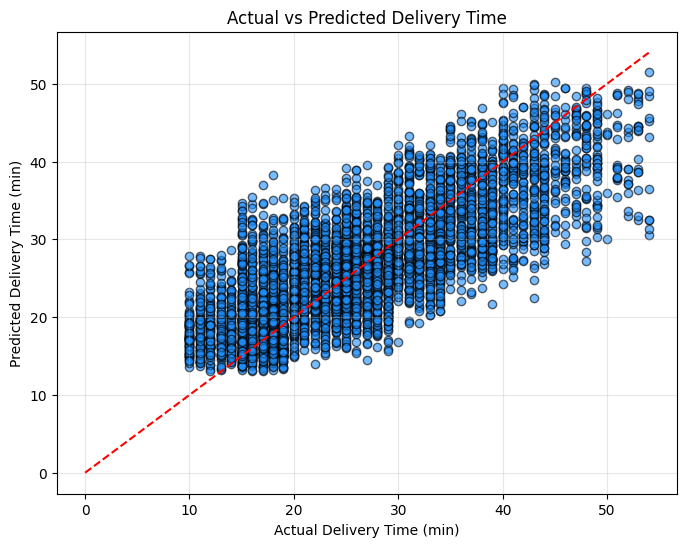

In [17]:
# Scatter plot of actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(test_df['time_taken_min'], test_df['predictions'], alpha=0.6, color='dodgerblue', edgecolor='k')
plt.plot([0, max(test_df['time_taken_min'])], [0, max(test_df['time_taken_min'])], color='red', linestyle='--')  # diagonal line

plt.xlabel("Actual Delivery Time (min)")
plt.ylabel("Predicted Delivery Time (min)")
plt.title("Actual vs Predicted Delivery Time")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
plt.savefig("actual_vs_predicted.png", dpi=300) 

<Figure size 640x480 with 0 Axes>